In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tqdm.notebook import tqdm

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from my_utils import tokenize_en, tokenize_ru

In [6]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [7]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = False,
            batch_first=True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

In [8]:
path_to_data = "../data.txt"

In [9]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [10]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [11]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [12]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [13]:
from cnn_cnn import Encoder, Decoder, Seq2Seq

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,839,142 trainable parameters


In [17]:
optimizer = optim.Adam(model.parameters())

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [26]:
from my_utils import train_cnn, evaluate_cnn, epoch_time

In [22]:
for x in train_iterator:
    break

In [23]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(x.src, x.trg[:,:-1]))
writer.close()

In [24]:
%load_ext tensorboard
%tensorboard --logdir runs

In [25]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/cnn_cnn.pt')
        
        
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 7s
	Train Loss: 4.177 | Train PPL:  65.197
	 Val. Loss: 2.794 |  Val. PPL:  16.349
Epoch: 02 | Time: 1m 7s
	Train Loss: 2.884 | Train PPL:  17.882
	 Val. Loss: 2.228 |  Val. PPL:   9.281
Epoch: 03 | Time: 1m 7s
	Train Loss: 2.445 | Train PPL:  11.528
	 Val. Loss: 1.969 |  Val. PPL:   7.165
Epoch: 04 | Time: 1m 7s
	Train Loss: 2.181 | Train PPL:   8.856
	 Val. Loss: 1.794 |  Val. PPL:   6.012
Epoch: 05 | Time: 1m 6s
	Train Loss: 1.994 | Train PPL:   7.348
	 Val. Loss: 1.682 |  Val. PPL:   5.376
Epoch: 06 | Time: 1m 7s
	Train Loss: 1.857 | Train PPL:   6.402
	 Val. Loss: 1.609 |  Val. PPL:   4.998
Epoch: 07 | Time: 1m 7s
	Train Loss: 1.748 | Train PPL:   5.746
	 Val. Loss: 1.562 |  Val. PPL:   4.769
Epoch: 08 | Time: 1m 7s
	Train Loss: 1.664 | Train PPL:   5.280
	 Val. Loss: 1.520 |  Val. PPL:   4.571
Epoch: 09 | Time: 1m 7s
	Train Loss: 1.593 | Train PPL:   4.918
	 Val. Loss: 1.489 |  Val. PPL:   4.432
Epoch: 10 | Time: 1m 7s
	Train Loss: 1.535 | Train PPL:   4.644


Модель не переобучилась, т.к. val_loss падал в течение всех 10 эпох.

In [15]:
model.load_state_dict(torch.load('./models/cnn_cnn.pt'))

<All keys matched successfully>

In [30]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_cnn(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 1.478 | Test PPL:   4.386 | Inference time if batch_size=32: 0.018 sec


In [28]:
from my_utils import cnn_display_attention, cnn_translate_sentence

In [29]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [30]:
translation, attention = cnn_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = в некоторых люксах установлена гидромассажная ванна . в том числе гидромассажная ванна . в распоряжении гостей гидромассажная ванна . <eos>


<ipython-input-28-29ba19def7ed>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-29ba19def7ed>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


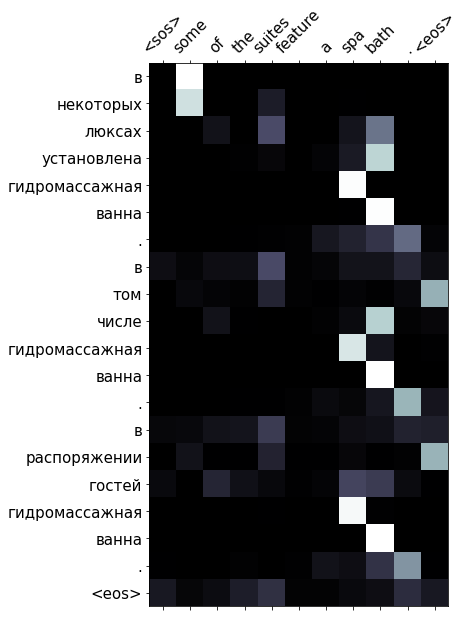

In [31]:
cnn_display_attention(src, translation, attention)

In [32]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = в отеле предоставляется завтрак . , а завтрак . в отеле проживания входит завтрак . . . . . предоставляется завтрак . . . . . . предоставляется по стоимость проживания . . . . . . . . . . . . . . . . . а предоставляется завтрак . <eos>


<ipython-input-28-29ba19def7ed>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-29ba19def7ed>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


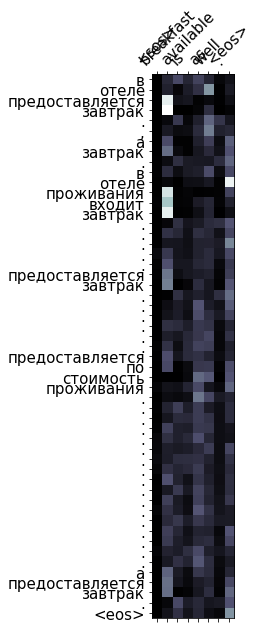

In [33]:
translation, attention = cnn_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

cnn_display_attention(src, translation, attention)

<ipython-input-28-29ba19def7ed>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-29ba19def7ed>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


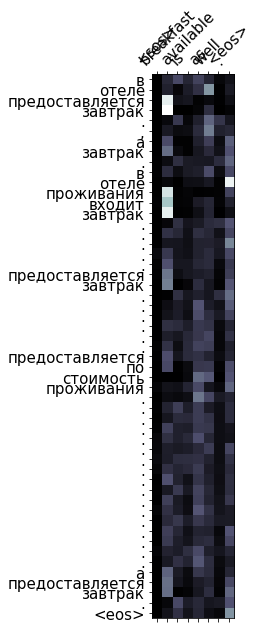

In [34]:
cnn_display_attention(src, translation, attention)

In [35]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей солнечная терраса с открытым бассейном и бар , бар и бар у бассейна . открытый бассейн и бар . <eos>


<ipython-input-28-29ba19def7ed>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-29ba19def7ed>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


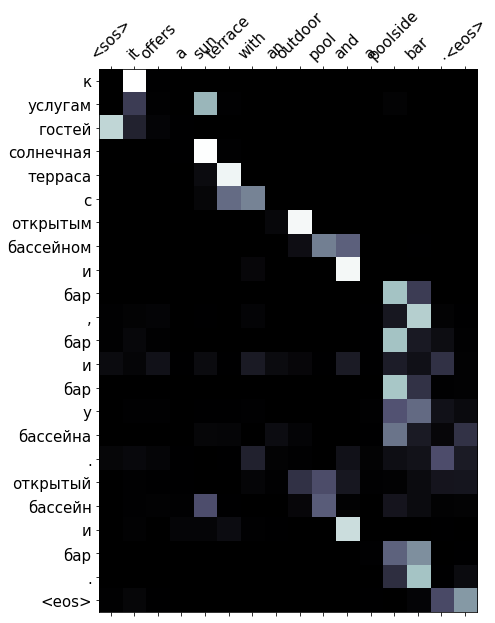

In [36]:
translation, attention = cnn_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

cnn_display_attention(src, translation, attention)

<ipython-input-28-29ba19def7ed>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-29ba19def7ed>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


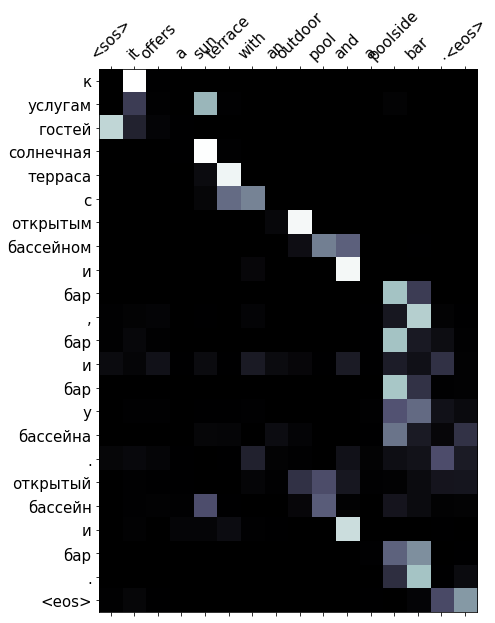

In [37]:
cnn_display_attention(src, translation, attention)

In [39]:
from my_utils import calculate_bleu

In [40]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device, max_len=100)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/7500 [00:00<?, ?it/s]

BLEU score = 10.32
